<a href="https://colab.research.google.com/github/maiaufrrj/BRtrading/blob/main/pvalor_IQR_ibov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install yfinance
#!pip install networkx
#!pip install plotly
#!pip install pickle5 
#!pip install fbprophet

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import plotly.graph_objs as go
from plotly.graph_objs import *
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from IPython.core.display import display, HTML

In [5]:
lista_ibov = pd.read_csv('https://raw.githubusercontent.com/maiaufrrj/BRtrading/main/lista_ibov.csv')['lista_ibov']

lista_acoes=[]
for i in range(len(lista_ibov)):
  lista_acoes.append(lista_ibov[i]+'.SA')
lista_ibov = list(lista_acoes)
del lista_acoes

In [45]:
import pickle5 as pickle

with open('df_teste.pkl', 'rb') as f:
  df = pickle.load(f)

#df = df_teste.dropna(axis='columns', thresh=200)

In [55]:
len(lista_ibov)

91

In [129]:
lista_pvalor=[]
#Teste de Dickey Fuller Aumentado - Verificando Estacionariedade
from statsmodels.tsa.stattools import adfuller
for acao in lista_ibov:
  try:
    X = df[acao].values
    result = adfuller(X)[1]
    #print(f'{acao} p-value: %f' % result)
    lista_pvalor.append(result)
  except:  
    pass #ignorando erros e seguindo no loop

In [ ]:
lista_iqr=[]

from scipy.stats import iqr
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet import Prophet

#Dividindo dataset
for acao in lista_ibov:
  try:
    ativo=pd.DataFrame(df[acao]).reset_index()
    half_rows=ativo.shape[0]/2
    ativo.dropna(thresh=half_rows)
    train_size = int(0.90 * len(ativo))
    test_size = len(ativo) - train_size

    univariate_df = ativo[['Date', acao]].copy()
    univariate_df.columns = ['ds', 'y']

    train = univariate_df.iloc[:train_size, :]

    x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
    x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

    #instanciando e treinando modelo
    model = Prophet(changepoint_prior_scale= 0.01, seasonality_prior_scale= 1.0, weekly_seasonality=True) #hiperparâmetros ajustados
    model.fit(train)
    future = model.make_future_dataframe(periods=360, freq='d')

    # Conjunto de Previsão
    y_pred = model.predict(future)
    initial=str(int(ativo.shape[0]*0.7)) + ' days'
    period=str((ativo.shape[0]*0.8)//4) + ' days'
    horizon=str((ativo.shape[0]*0.8)//12) + ' days'
    df_cv = cross_validation(model, initial=initial, period=period, horizon = horizon)
    relatorio_cv = performance_metrics(df_cv)
    
    intervalo_interquartil = iqr(relatorio_cv['mape'])
    lista_iqr.append([acao, intervalo_interquartil])
  except:
    pass

In [ ]:
#lista_iqr

In [95]:
lista_acao_iqr=[]
for i in range(len(lista_iqr)):
   lista_acao_iqr.append(lista_iqr[i][0])

In [97]:
lista_valores_iqr=[]
for i in range(len(lista_iqr)):
   lista_valores_iqr.append(lista_iqr[i][1])

In [143]:
lista1=[]
for i in range(len(lista_pvalor)):
   lista1.append(list([lista_ibov[i], lista_pvalor[i]]))

In [179]:
df_pvalor = pd.DataFrame(lista1)
df_pvalor['Ação']=df_pvalor[0]
df_pvalor['p-valor']=df_pvalor[1]
df_pvalor.drop(columns=[0, 1], inplace=True)
df_pvalor.set_index(keys='Ação', inplace=True)
df_pvalor.head()

,p-valor
Ação,
ALPA4.SA,0.666042
ABEV3.SA,0.268614
AMER3.SA,0.766190
ASAI3.SA,0.069981
AZUL4.SA,0.965578


In [180]:
df_iqr = pd.DataFrame(lista_iqr)
df_iqr['Ação']=df_iqr[0]
df_iqr['IQR_metrica']=df_iqr[1]
df_iqr.drop(columns=[0, 1], inplace=True)
df_iqr.set_index(keys='Ação', inplace=True)
df_iqr.head()

,IQR_metrica
Ação,
ALPA4.SA,0.023624
ABEV3.SA,0.011517
AMER3.SA,0.055376
AZUL4.SA,0.039463
B3SA3.SA,0.020558


In [181]:
print(df_pvalor.shape[0], df_iqr.shape[0])

87 90


In [183]:
df_final = pd.concat([df_pvalor, df_iqr], axis=1, join="inner")
df_final.head()

,p-valor,IQR_metrica
Ação,,
ALPA4.SA,0.666042,0.023624
ABEV3.SA,0.268614,0.011517
AMER3.SA,0.766190,0.055376
AZUL4.SA,0.965578,0.039463
B3SA3.SA,0.418433,0.020558


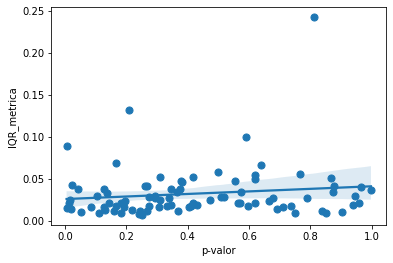

In [192]:
import seaborn as sns
sns.regplot(data=df_final, x="p-valor", y="IQR_metrica",  x_estimator=np.mean)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



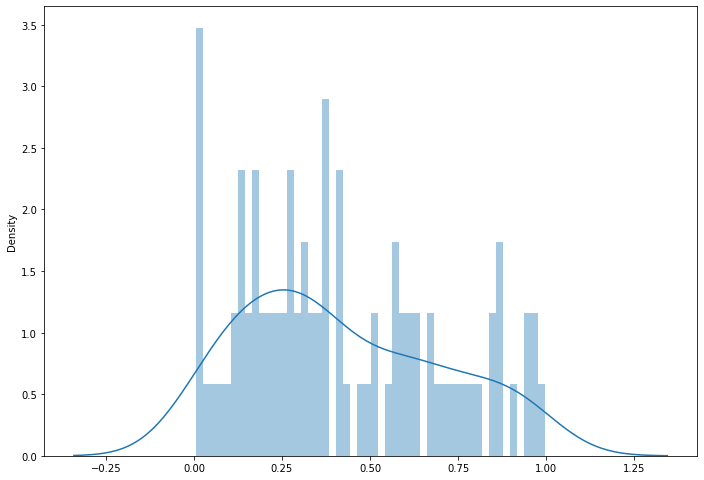

In [206]:
a4_dims = (11.7, 8.27)
fig, ax1 = plt.subplots(figsize=a4_dims)
ax1 = sns.distplot(lista_pvalor, bins=50)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



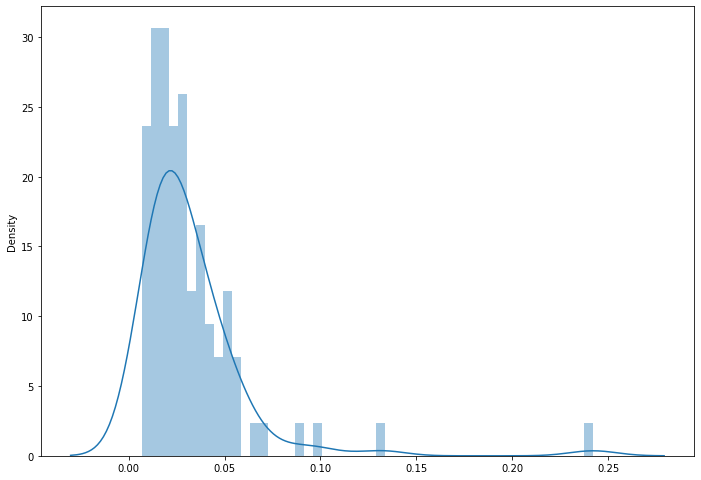

In [205]:
a4_dims = (11.7, 8.27)
fig, ax2 = plt.subplots(figsize=a4_dims)
ax2 = sns.distplot(lista_valores_iqr, bins=50)